In [1]:
year = None
month = None
program = "prepilot"
include_replaced_modes_as_valid = False # Flip this when we want to get results versus generate the replaced_mode correction graphs
input_dataset = "ONLY_SENSED" # "ONLY_LABELED", "ONLY_SENSED" or "BEST_AVAILABLE" for sensitivity analysis
LABEL_ASSIST_THRESHOLD = 0.3

In [2]:
import pandas as pd

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import scaffolding
from uuid import UUID

%matplotlib inline

Connecting to database URL db


### Load

In [3]:
# Split UUIDs by program
program_uuid_map = {}
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    if program in program_uuid_map.keys():
        program_uuid_map[program].append(str(ue['uuid']))
    else:
        print(f"Found new program {program}, creating new list")
        program_uuid_map[program] = []
        program_uuid_map[program].append(str(ue['uuid']))

Found new program vail, creating new list
Found new program sc, creating new list
Found new program 4c, creating new list
Found new program fc, creating new list
Found new program stage, creating new list
Found new program pc, creating new list
Found new program cc, creating new list


In [4]:
uuid_program_list = []
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    uuid_program_list.append({"program": program, "opcode": ue["user_email"], "user_id_str": str(ue['uuid'])})

In [5]:
program_uuid_map.keys()

dict_keys(['vail', 'sc', '4c', 'fc', 'stage', 'pc', 'cc'])

In [6]:
uuid_program_df = pd.DataFrame.from_dict(uuid_program_list)
uuid_program_df.head()

,program,opcode,user_id_str
0,vail,vail_7XujlKOYzJ2MmWh1,bd9cffc8-dbf1-402d-a479-f9f148ec9e60
1,vail,vail_4_BrvglmpUQk6dSv,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3
2,vail,vail_14aC2LJ1c-gG_mGb,f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0
3,vail,vail_Fu-HHHSegEum1AbC,8b1f3ba4-3de9-45be-a79d-e6a81716ad04
4,vail,vail_vJyqw9Bpjk4rynQ8,9606d610-4d24-4960-a77d-9211c5b587ec


In [7]:
uuid_program_df.loc[uuid_program_df.groupby("program").groups['4c']]

,program,opcode,user_id_str
22,4c,4c_Ze5Y_li7r4MOsbqj,863e9c6c-8ec0-48c4-b765-3f73d839c85b
23,4c,4c_AGgrHoywg5gYmyL8,c6e4db31-c18b-4355-b02a-7dd97deca70b
24,4c,4c_Ri332Xj3DKaCrdwl,c6807997-194c-4c52-8a8f-a8c1f6ee1595
25,4c,4c_6gzfgbVUODrbTdc_,e9e479e9-5c3f-4345-a885-dadb7999b312
26,4c,4c_eJEIg2mWQYU3ISXU,6656c04c-6cba-4c18-9fed-805eaa529741
27,4c,4c_s7jHZr7a0yQOAa1b,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d
28,4c,4c_zo3s-4h_XC9SWygF,9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98
29,4c,4c_rsW7GeiQJR3HVBby,509b9093-9093-4e98-8eb1-20b58ed9bd8c
30,4c,4c_rjfwBKd_E-LDrcGU,e192b8a0-0b6c-4222-9685-1c93785deaf7
31,4c,4c_7gkYfJJBJlb4Iat1,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d


In [8]:
program_uuid_map['4c']

['863e9c6c-8ec0-48c4-b765-3f73d839c85b',
 'c6e4db31-c18b-4355-b02a-7dd97deca70b',
 'c6807997-194c-4c52-8a8f-a8c1f6ee1595',
 'e9e479e9-5c3f-4345-a885-dadb7999b312',
 '6656c04c-6cba-4c18-9fed-805eaa529741',
 '9910245f-ee4e-4cca-ab4c-dd2312eb0d5d',
 '9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98',
 '509b9093-9093-4e98-8eb1-20b58ed9bd8c',
 'e192b8a0-0b6c-4222-9685-1c93785deaf7',
 '2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d',
 '56e23e21-6152-4f59-9253-50bd28a5d7f9',
 '840297ae-3948-4e26-bfeb-e83ee30c5b3e',
 'd7a732f4-a864-4bcb-b8de-dfc8be242fb2',
 '5ad862e7-9a63-41f6-9f28-c0096fe884da',
 '21c78a1c-6df2-4097-b289-5a784610991b',
 'e4cfb2a8-f600-4268-9756-9985e234636e']

In [9]:
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('bd9cffc8-dbf1-402d-a479-f9f148ec9e60'),
 UUID('fc8f71a3-8c82-458d-bf97-18c3ee11a0f3'),
 UUID('f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0'),
 UUID('8b1f3ba4-3de9-45be-a79d-e6a81716ad04'),
 UUID('9606d610-4d24-4960-a77d-9211c5b587ec'),
 UUID('15eb78dd-6e10-4966-ba61-12589c29dc41'),
 UUID('e5015494-1416-43f9-a2e6-fb845e1e9183'),
 UUID('15aa4ba1-44a3-4b8b-8079-ed7e049d84df'),
 UUID('b36f7b55-65a3-40d8-aa97-0590bfb14782'),
 UUID('7abe5721-4886-4412-a339-79592fa985fb'),
 UUID('8fdc9b92-6a67-4a9e-a07d-91df2c5e06f2'),
 UUID('fbff5e08-b7f2-4a94-ab4b-2d7371999ef7'),
 UUID('a7e9b775-6b3a-439d-b110-0472e5954230'),
 UUID('742fbefa-e7d7-45a9-bdf6-44659d21e0fa'),
 UUID('f0db3b19-99c2-410b-a593-3103eca9212f'),
 UUID('37bc8629-38aa-470a-bd9d-2aaf3c2ac680'),
 UUID('8c3c63ab-b3ec-4fc3-a61e-7bf316ee4efd'),
 UUID('367eb90b-929d-4f6e-9470-d15c700d2e3f'),
 UUID('b4500762-e0f0-432b-9d1a-35a028715f18'),
 UUID('858936a7-bf62-466b-8bee-af3ae6161cb9'),
 UUID('b1aed24c-8639-49bf-bfa3-a844ecf60593'),
 UUID('ea557d

Loaded all confirmed trips of length 135471


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,...,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,...,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,...,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,...,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,...,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09


After filtering, found 135471 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,...,9,20,16,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,...,9,20,16,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,...,9,20,17,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,...,9,20,17,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09
4,DwellSegmentationDistFilter,1.632230e+09,2021-09-21T07:15:51.546062-06:00,"{'type': 'Point', 'coordinates': [-106.3814560...",6149df8762cecc2c7249b624,1.632229e+09,2021-09-21T06:59:10.899343-06:00,"{'type': 'Point', 'coordinates': [-106.3954507...",1000.646719,2060.997718,...,9,21,7,15,51,1,America/Denver,6149df8862cecc2c7249b65d,fc8f71a3-8c82-458d-bf97-18c3ee11a0f3,1.632231e+09


In [10]:
participant_ct_df["user_id_str"] = participant_ct_df.user_id.apply(lambda u: str(u))
len(participant_ct_df.user_id_str.unique())

219

### Transform

In [11]:
trip_program_df = participant_ct_df.merge(uuid_program_df, on="user_id_str")

In [12]:
trip_program_df.sample(n=50, random_state=123)[["program", "user_id_str", "opcode", "_id", "start_fmt_time", "end_fmt_time"]]

,program,user_id_str,opcode,_id,start_fmt_time,end_fmt_time
120887,cc,ecd2ae17-d518-4807-abd8-7a287115c299,cc_gJO9BhrI1vb-trpb,6264c756420106962102ef04,2022-04-23T21:09:22.586813-06:00,2022-04-23T21:16:40.999384-06:00
123447,cc,3dddfb70-e7cd-40f1-8a63-478654182e9a,cc_sStlnAaiSzf58qsb,61208dd4ec71d0bb1a28fbd6,2021-08-17T12:10:09.595453-06:00,2021-08-17T12:41:54.000262-06:00
48821,stage,1fdbfb17-5168-445a-8c2b-14efd528ccdd,stage_rDuumFma4Ao,61310776a5e1809d2cb87d64,2021-09-02T11:13:55.352423-05:00,2021-09-02T11:57:27.873301-05:00
3583,sc,742fbefa-e7d7-45a9-bdf6-44659d21e0fa,sc_J-ArOjMlWoNLiJpR,6140f4e9ecca4f005896d7d8,2021-09-14T11:41:37.007758-06:00,2021-09-14T12:03:51.689000-06:00
121108,cc,5182d93d-6975-4d7b-a062-00cd1ac5980a,cc_lBkxWvyLkJcRhYTs,612570166c151b6274160971,2021-08-24T15:51:45.755373-06:00,2021-08-24T16:03:54.573010-06:00
14419,4c,56e23e21-6152-4f59-9253-50bd28a5d7f9,4c_USe9VQfJVTGobNyu,617e0a76c2be436e48e7894c,2021-10-30T20:17:43.587313-06:00,2021-10-30T20:27:31.372000-06:00
25879,fc,3f067105-255e-4b0c-a1ba-b377fee7ef16,fc_csu_GR6mh4Zd9sDqvB86,62783397b4b2aeedcb9e7124,2022-05-08T14:56:45.806315-06:00,2022-05-08T15:02:22.348000-06:00
107951,cc,c7ce889c-796f-4e2a-8859-fa2d7d5068fe,cc_gro6SkBCtkj2FOrF,61a9002a993981438c336528,2021-12-02T09:07:08.692000-07:00,2021-12-02T09:15:54.061000-07:00
70739,pc,0b3e78fa-91d8-4aa6-a320-3440143c8c16,pc_ff3Wiw3Z-Yg2cFqV,622fa3fa4db6a89ef1b85f71,2022-03-14T12:54:40.853870-06:00,2022-03-14T13:02:06-06:00
54160,stage,fa0b0e30-1726-490a-a705-c2243ad37bbf,stage_BNtQen1bipo,614b3b450b1f97dd4008fb02,2021-09-22T07:30:05.884937-06:00,2021-09-22T08:09:15.999900-06:00


In [13]:
labeled_ct = scaffolding.filter_labeled_trips(trip_program_df)

After filtering, found 57729 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,program,opcode
0,DwellSegmentationTimeFilter,1.632176e+09,2021-09-20T16:15:00.051000-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",61490c97298be5cdcb8ed736,1.632175e+09,2021-09-20T16:00:08-06:00,"{'type': 'Point', 'coordinates': [-106.3676619...",892.051000,15145.485855,...,15,0,0,America/Denver,61490ca0298be5cdcb8ed76b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632177e+09,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,vail,vail_7XujlKOYzJ2MmWh1
1,DwellSegmentationTimeFilter,1.632177e+09,2021-09-20T16:32:09-06:00,"{'type': 'Point', 'coordinates': [-106.5195394...",61491aa7b9593ff96f7257cd,1.632177e+09,2021-09-20T16:30:32.960140-06:00,"{'type': 'Point', 'coordinates': [-106.5175529...",96.039860,211.492836,...,32,9,0,America/Denver,61491aafb9593ff96f72580a,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,vail,vail_7XujlKOYzJ2MmWh1
2,DwellSegmentationTimeFilter,1.632179e+09,2021-09-20T17:05:55.326000-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",61491aa7b9593ff96f7257cf,1.632179e+09,2021-09-20T16:56:13.353779-06:00,"{'type': 'Point', 'coordinates': [-106.5197294...",581.972221,4412.821082,...,5,55,0,America/Denver,61491aafb9593ff96f72580b,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632181e+09,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,vail,vail_7XujlKOYzJ2MmWh1
3,DwellSegmentationTimeFilter,1.632181e+09,2021-09-20T17:33:15-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",614928b7dd5719f85e04c576,1.632180e+09,2021-09-20T17:19:25.349600-06:00,"{'type': 'Point', 'coordinates': [-106.4774116...",829.650400,12611.088373,...,33,15,0,America/Denver,614928c0dd5719f85e04c5a8,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632185e+09,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,vail,vail_7XujlKOYzJ2MmWh1
4,DwellSegmentationTimeFilter,1.632268e+09,2021-09-21T17:44:52-06:00,"{'type': 'Point', 'coordinates': [-106.380365,...",614a7a38b50992891e5980ff,1.632266e+09,2021-09-21T17:12:16.910905-06:00,"{'type': 'Point', 'coordinates': [-106.3541358...",1955.089095,3204.806663,...,44,52,1,America/Denver,614a7a39b50992891e598157,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1.632271e+09,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,vail,vail_7XujlKOYzJ2MmWh1


In [14]:
label_summary_df = pd.DataFrame({"total_trips": trip_program_df.groupby("program").source.count(), "labeled_trips": labeled_ct.groupby("program").source.count()})
label_summary_df

,total_trips,labeled_trips
program,,
4c,10121,4382
cc,40612,19546
fc,19954,7856
pc,27337,11253
sc,10805,5318
stage,23821,7334
vail,2821,2040


In [15]:
label_summary_df["label_pct"] = (label_summary_df.labeled_trips / label_summary_df.total_trips) * 100

In [16]:
label_summary_df

,total_trips,labeled_trips,label_pct
program,,,
4c,10121,4382,43.296117
cc,40612,19546,48.128632
fc,19954,7856,39.370552
pc,27337,11253,41.163990
sc,10805,5318,49.217955
stage,23821,7334,30.787960
vail,2821,2040,72.314782


In [17]:
label_user_summary_df = pd.DataFrame({"total_trips": trip_program_df.groupby(["program", "user_id_str"]).source.count(), "labeled_trips": labeled_ct.groupby(["program", "user_id_str"]).source.count()})

In [18]:
label_user_summary_df["label_pct"] = (label_user_summary_df.labeled_trips / label_user_summary_df.total_trips) * 100
label_user_summary_df

total_trips  labeled_trips  \
program user_id_str                                                        
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d          236          153.0   
        509b9093-9093-4e98-8eb1-20b58ed9bd8c          389          298.0   
        56e23e21-6152-4f59-9253-50bd28a5d7f9         1247          806.0   
        5ad862e7-9a63-41f6-9f28-c0096fe884da         1413          640.0   
        6656c04c-6cba-4c18-9fed-805eaa529741         1188          117.0   
...                                                   ...            ...   
vail    8b1f3ba4-3de9-45be-a79d-e6a81716ad04          350          136.0   
        9606d610-4d24-4960-a77d-9211c5b587ec           46           35.0   
        bd9cffc8-dbf1-402d-a479-f9f148ec9e60         1075         1018.0   
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0          228          148.0   
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3          522          518.0   

                                              label_pct  
program user_id_str                                      
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d  64.830508  
        509b9093-9093-4e98-8eb1-20b58ed9bd8c  76.606684  
        56e23e21-6152-4f59-9253-50bd28a5d7f9  64.635124  
        5ad862e7-9a63-41f6-9f28-c0096fe884da  45.293701  
        6656c04c-6cba-4c18-9fed-805eaa529741   9.848485  
...                                                 ...  
vail    8b1f3ba4-3de9-45be-a79d-e6a81716ad04  38.857143  
        9606d610-4d24-4960-a77d-9211c5b587ec  76.086957  
        bd9cffc8-dbf1-402d-a479-f9f148ec9e60  94.697674  
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0  64.912281  
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3  99.233716  

[219 rows x 3 columns]

### Plot

<AxesSubplot:title={'center':'Variation in labeling percentage across programs'}, xlabel='program', ylabel='% of labeled trips'>

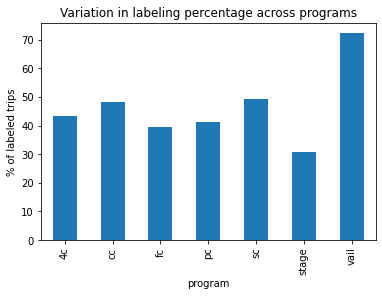

In [19]:
label_summary_df.label_pct.plot(kind="bar", ylabel="% of labeled trips", title="Variation in labeling percentage across programs")

Text(0.5, 1.0, 'Percentage of trips labeled by each user')

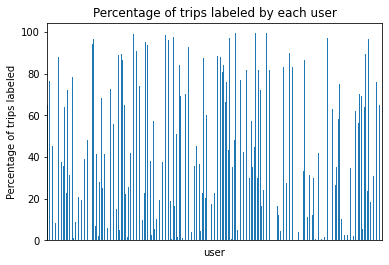

In [20]:
ax=label_user_summary_df.label_pct.plot(kind="bar", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by each user")

In [21]:
flattened_label_user_summary_df = label_user_summary_df.reset_index()

In [22]:
flattened_label_user_summary_df

,program,user_id_str,total_trips,labeled_trips,label_pct
0,4c,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,236,153.0,64.830508
1,4c,509b9093-9093-4e98-8eb1-20b58ed9bd8c,389,298.0,76.606684
2,4c,56e23e21-6152-4f59-9253-50bd28a5d7f9,1247,806.0,64.635124
3,4c,5ad862e7-9a63-41f6-9f28-c0096fe884da,1413,640.0,45.293701
4,4c,6656c04c-6cba-4c18-9fed-805eaa529741,1188,117.0,9.848485
...,...,...,...,...,...
214,vail,8b1f3ba4-3de9-45be-a79d-e6a81716ad04,350,136.0,38.857143
215,vail,9606d610-4d24-4960-a77d-9211c5b587ec,46,35.0,76.086957
216,vail,bd9cffc8-dbf1-402d-a479-f9f148ec9e60,1075,1018.0,94.697674
217,vail,f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0,228,148.0,64.912281


Text(0.5, 0.98, 'Labeling rate by program')

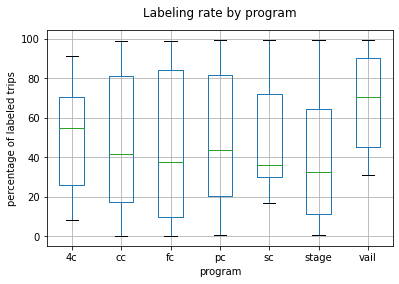

In [23]:
ax = flattened_label_user_summary_df.boxplot(column=['label_pct'], by="program")
type(ax)
ax.set_title("")
ax.set_ylabel("percentage of labeled trips")
ax.get_figure().suptitle("Labeling rate by program")

Text(0.5, 1.0, 'Percentage of trips labeled by user')

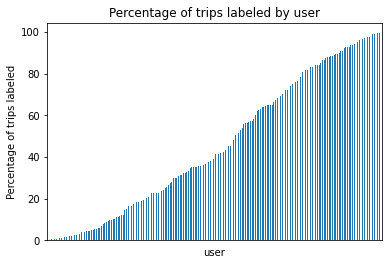

In [24]:
ax = flattened_label_user_summary_df.dropna().sort_values(by="label_pct").label_pct.plot.bar(y="label_pct", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by user")

In [25]:
import seaborn as sns

Text(0.5, 1.0, 'Mean labeling rate and variance per program')

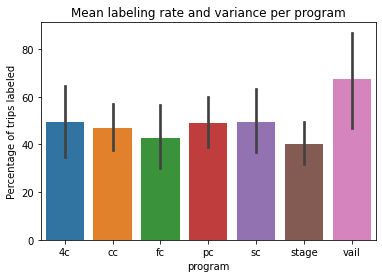

In [26]:
ax=sns.barplot(data=flattened_label_user_summary_df, x="program", y="label_pct")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Mean labeling rate and variance per program")

### Describe

In [27]:
def describe_label_info(df):
    print(f"Total number of trips {len(df)} from {len(df.user_id.unique())} unique users")
    print(f"Number of trips with at least one label {len(df[df.user_input != {}])} from {len(df[df.user_input != {}].user_id.unique())} unique users")
    no_user_label_ct_df = df[df.user_input == {}]
    print(f"Trips without user specified labels {len(no_user_label_ct_df)} from {len(no_user_label_ct_df.user_id.unique())} users")
    is_empty_check = lambda ll: len(ll) == 0
    print(f"Trips without user label but with inferred label {len(no_user_label_ct_df[~no_user_label_ct_df.inferred_labels.apply(is_empty_check)])}")
    print(f"Trips without user label or inferred label {len(no_user_label_ct_df[no_user_label_ct_df.inferred_labels.apply(is_empty_check)])}")
    stage_df = df[df.program == 'stage']
    print(f"Number of trips in stage = {len(df[df.program=='stage'])} from {len(df[df.program=='stage'].user_id.unique())} unique users")
    print(f"Number of trips in real programs = {len(df[df.program!='stage'])} from {len(df[df.program!='stage'].user_id.unique())} unique users")
    trip_count_df = df.groupby("program").source.count()
    user_count_df = df.groupby("program").user_id.unique().apply(lambda unique_list: len(unique_list))
    # print(trip_count_df)
    # print(user_count_df)
    count_df = pd.DataFrame({"trips": trip_count_df, "unique_users": user_count_df})
    # print(count_df)
    print(f"Program specific counts: ", count_df.to_dict())

In [28]:
describe_label_info(trip_program_df)

Total number of trips 135471 from 219 unique users
Number of trips with at least one label 57729 from 200 unique users
Trips without user specified labels 77742 from 219 users
Trips without user label but with inferred label 33550
Trips without user label or inferred label 44192
Number of trips in stage = 23821 from 70 unique users
Number of trips in real programs = 111650 from 149 unique users
Program specific counts:  {'trips': {'4c': 10121, 'cc': 40612, 'fc': 19954, 'pc': 27337, 'sc': 10805, 'stage': 23821, 'vail': 2821}, 'unique_users': {'4c': 14, 'cc': 48, 'fc': 29, 'pc': 39, 'sc': 13, 'stage': 70, 'vail': 6}}


In [29]:
describe_label_info(labeled_ct)

Total number of trips 57729 from 200 unique users
Number of trips with at least one label 57729 from 200 unique users
Trips without user specified labels 0 from 0 users
Trips without user label but with inferred label 0
Trips without user label or inferred label 0
Number of trips in stage = 7334 from 54 unique users
Number of trips in real programs = 50395 from 146 unique users
Program specific counts:  {'trips': {'4c': 4382, 'cc': 19546, 'fc': 7856, 'pc': 11253, 'sc': 5318, 'stage': 7334, 'vail': 2040}, 'unique_users': {'4c': 14, 'cc': 47, 'fc': 29, 'pc': 37, 'sc': 13, 'stage': 54, 'vail': 6}}
